# Multi-Scale Driver Interactions on Phenology via Graph-Based Ensembled ML
*Enhanced Multi-Scale Driver Interactions Framework*

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import os
from datetime import datetime, timedelta

print("✅Done!")

✅Done!


#### ==========================================================================
<h3 align="center">SECTION 1: CONFIGURATION (setup ee api)</h3>

#### ==========================================================================

In [2]:
print("Initializing Earth Engine...")
try:
    ee.Authenticate()  # Run once
    ee.Initialize(project="ee-cheruiyotkb")

    AOI_ASSET = "projects/ee-cheruiyotkb/assets/muringato_maizeFarms"
    years = [2000, 2003, 2006, 2009, 2012, 2015, 2018, 2021, 2023, 2024]  # Extended for multi-year analysis
    start_month_day = "-03-20"
    end_month_day = "-08-31"
    aoi = ee.FeatureCollection(AOI_ASSET).geometry()

    print("✅Successful")
except:
    print("❗An error occurred")

Initializing Earth Engine...
✅Successful


#### ============================================================================
<h3 align="center"> SECTION 2: RANDOM POINTS GENERATION </h3>

#### ============================================================================

In [3]:
print("Generating 1000 random sampling points...")
points_raw = ee.FeatureCollection.randomPoints(region=aoi, points=1000, seed=42)
def add_index_and_coords(index):
    def wrapper(feature):
        coords = feature.geometry().coordinates()
        return feature.set({
            'index': index + 1,
            'longitude': coords.get(0),
            'latitude': coords.get(1)
        })
    return wrapper

points_list = points_raw.toList(points_raw.size())
points = ee.FeatureCollection([add_index_and_coords(i)(ee.Feature(points_list.get(i))) 
                                for i in range(1000)])
print("✅1000 random points generated!")

Generating 1000 random sampling points...
✅1000 random points generated!


#### ========================================================================
<h3 align="center"> PLOT THE POINTS </h3>

#### ========================================================================

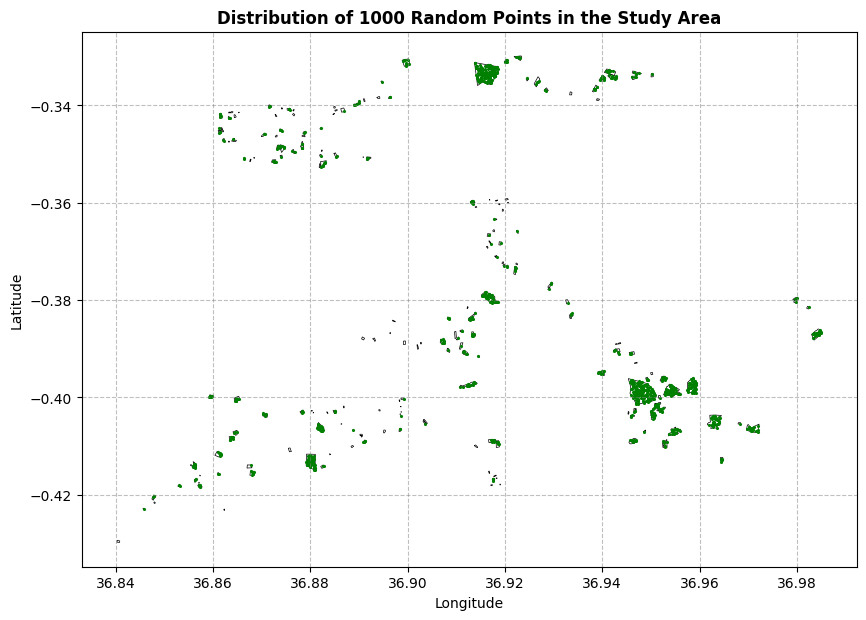

In [4]:
# Get AOI geometry information
aoi_info = aoi.getInfo()

# Handle different possible geometry structures
geom_type = aoi_info.get('type', None)

if geom_type == 'Polygon':
    aoi_geom = Polygon(aoi_info['coordinates'][0])

elif geom_type == 'MultiPolygon':
    aoi_geom = MultiPolygon([Polygon(coords[0]) for coords in aoi_info['coordinates']])

elif geom_type == 'GeometryCollection':
    # Combine all polygon parts into a single MultiPolygon
    polygons = []
    for geom in aoi_info['geometries']:
        if geom['type'] == 'Polygon':
            polygons.append(Polygon(geom['coordinates'][0]))
        elif geom['type'] == 'MultiPolygon':
            for coords in geom['coordinates']:
                polygons.append(Polygon(coords[0]))
    aoi_geom = MultiPolygon(polygons)

else:
    raise ValueError(f"Unsupported AOI geometry type: {geom_type}")

# Convert Earth Engine points to Pandas DataFrame
points_df = geemap.ee_to_df(points)

# Convert to GeoDataFrame
points_gdf = gpd.GeoDataFrame(
    points_df,
    geometry=gpd.points_from_xy(points_df.longitude, points_df.latitude),
    crs='EPSG:4326'
)

# Convert to GeoDataFrame
aoi_gdf = gpd.GeoDataFrame({'geometry': [aoi_geom]}, crs='EPSG:4326')

# Plot
ax = aoi_gdf.plot(edgecolor='black', facecolor='none', linewidth=0.5, figsize=(10, 10))
points_gdf.plot(ax=ax, color='green', marker= "*", markersize=2)
plt.title("Distribution of 1000 Random Points in the Study Area", fontweight='bold')
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.5, color='gray', linestyle='--')
plt.show()

#### ============================================================================
<h3 align="center">SECTION 3: STATIC FEATURES </h3>

#### ============================================================================

In [5]:
print("\n📊 Extracting STATIC topographic and soil features...")

# Topographic features
dem = ee.Image("USGS/SRTMGL1_003").select('elevation').clip(aoi)
slope = ee.Terrain.slope(dem).rename('slope')
aspect = ee.Terrain.aspect(dem).rename('aspect')

# Derive additional topographic features for multi-scale analysis
hillshade = ee.Terrain.hillshade(dem).rename('hillshade')
tpi = dem.subtract(dem.focal_mean(radius=500, units='meters')).rename('tpi')  # Topographic Position Index

# Soil properties from ISDASOIL
ph = ee.Image("ISDASOIL/Africa/v1/ph").select('mean_0_20').divide(10).rename('ph')
clay = ee.Image("ISDASOIL/Africa/v1/clay_content").select('mean_0_20').rename('clay')
organic = ee.Image("ISDASOIL/Africa/v1/carbon_organic").select('mean_0_20').rename('organic')
nitrogen = ee.Image("ISDASOIL/Africa/v1/nitrogen_total").select('mean_0_20').rename('nitrogen')
sand = ee.Image("ISDASOIL/Africa/v1/sand_content").select('mean_0_20').rename('sand')
silt = ee.Image("ISDASOIL/Africa/v1/silt_content").select('mean_0_20').rename('silt')

# Stack all static layers
static_stack = dem.rename('elevation') \
    .addBands([slope, aspect, hillshade, tpi, 
               ph, clay, sand, silt, organic, nitrogen])

# Extract at points
static_features = static_stack.reduceRegions(
    collection=points,
    reducer=ee.Reducer.first(),
    scale=250
)

static_df = geemap.ee_to_df(static_features)
column_order = ['index', 'longitude', 'latitude'] + \
               [col for col in static_df.columns if col not in ['index', 'longitude', 'latitude', 'geometry']]
static_df = static_df[column_order]
print(f"✅ Static data extracted for {len(static_df)} points")
print(f"   Features: {list(static_df.columns[3:])}")


📊 Extracting STATIC topographic and soil features...
✅ Static data extracted for 1000 points
   Features: ['aspect', 'clay', 'elevation', 'hillshade', 'nitrogen', 'organic', 'ph', 'sand', 'silt', 'slope', 'tpi']


#### ============================================================================
<h3 align="center"> SECTION 4: DYNAMIC CLIMATE FEATURES (Critical for this research)</h3>

#### ============================================================================

In [6]:
print("\n🌡️ Extracting DYNAMIC climate features...")

def extract_dynamic_climate(year, points, aoi):
    """
    Extract temporal climate variables for a given year
    """
    start_date = f"{year}{start_month_day}"
    end_date = f"{year}{end_month_day}"
    
    # ERA5 Climate data
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterDate(start_date, end_date) \
        .select([
            'temperature_2m', 'dewpoint_temperature_2m', 
            'total_precipitation_sum', 'surface_solar_radiation_downwards_sum',
            'u_component_of_wind_10m', 'v_component_of_wind_10m'
        ])
    # Calculate individual climate variables
    # Temperature stats
    temp_mean = era5.select('temperature_2m').mean().subtract(273.15).rename('temp_mean')
    temp_min = era5.select('temperature_2m').min().subtract(273.15).rename('temp_min')
    temp_max = era5.select('temperature_2m').max().subtract(273.15).rename('temp_max')
    temp_std = era5.select('temperature_2m').reduce(ee.Reducer.stdDev()).rename('temp_std')
    
    # Precipitation stats
    precip_total = era5.select('total_precipitation_sum').sum().multiply(1000).rename('precip_total')
    precip_mean = era5.select('total_precipitation_sum').mean().multiply(1000).rename('precip_mean')
    precip_std = era5.select('total_precipitation_sum').reduce(ee.Reducer.stdDev()).multiply(1000).rename('precip_std')
    
    # Other variables
    radiation_mean = era5.select('surface_solar_radiation_downwards_sum').mean().rename('radiation_mean')
    dewpoint_mean = era5.select('dewpoint_temperature_2m').mean().subtract(273.15).rename('dewpoint_mean')
    
    # Wind speed
    wind_u = era5.select('u_component_of_wind_10m').mean()
    wind_v = era5.select('v_component_of_wind_10m').mean()
    wind_mean = wind_u.expression('sqrt(u**2 + v**2)', {
        'u': wind_u, 'v': wind_v
    }).rename('wind_mean')
    
    # DEBUG: Print band names to verify
    # print(f"    DEBUG - Band names in climate stack:")
    
    # Create climate stack
    climate_stack = ee.Image.cat([
        temp_mean, temp_min, temp_max, temp_std,
        precip_total, precip_mean, precip_std,
        radiation_mean, dewpoint_mean, wind_mean
    ])
    
    # Verify the band names
    # band_names = climate_stack.bandNames().getInfo()
    # print(f"    DEBUG - Band names: {band_names}")
    
    # Extract at points using toList to preserve all properties
    def extract_point_features(feature):
        point = ee.Feature(feature)
        geometry = point.geometry()
        # Sample all bands at this point
        sample = climate_stack.sample(geometry, 27000).first()
        # Get all band values
        band_values = sample.toDictionary()
        # Return feature with all climate variables
        return point.set(band_values)
    
    # Map over all points
    climate_features = points.map(extract_point_features)
    
    # Convert to dataframe
    climate_df = geemap.ee_to_df(climate_features)
    climate_df['year'] = year
    # print(f"    DEBUG - DataFrame columns: {list(climate_df.columns)}")
    return climate_df

# Extract for each year
climate_dfs = []
for year in years:
    print(f"  Processing year {year}...")
    try:
        climate_df = extract_dynamic_climate(year, points, aoi)
        climate_dfs.append(climate_df)
        print(f"    Successfully extracted {len(climate_df.columns)} columns")
    except Exception as e:
        print(f"    Error processing year {year}: {e}")

if climate_dfs:
    climate_df_all = pd.concat(climate_dfs, ignore_index=True)
    
    print(f"\n✅ FINAL RESULT:")
    print(f"   Total records: {len(climate_df_all)}")
    print(f"   Columns: {list(climate_df_all.columns)}")
    print(f"   Shape: {climate_df_all.shape}")
    
    # Display the table
    print("\n📋 CLIMATE DATA TABLE:")
    print("=" * 80)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(climate_df_all.head(10))
    
else:
    print("❌ No data was extracted!")

climate_df_all


🌡️ Extracting DYNAMIC climate features...
  Processing year 2000...
    Successfully extracted 14 columns
  Processing year 2003...
    Successfully extracted 14 columns
  Processing year 2006...
    Successfully extracted 14 columns
  Processing year 2009...
    Successfully extracted 14 columns
  Processing year 2012...
    Successfully extracted 14 columns
  Processing year 2015...
    Successfully extracted 14 columns
  Processing year 2018...
    Successfully extracted 14 columns
  Processing year 2021...
    Successfully extracted 14 columns
  Processing year 2023...
    Successfully extracted 14 columns
  Processing year 2024...
    Successfully extracted 14 columns

✅ FINAL RESULT:
   Total records: 10000
   Columns: ['dewpoint_mean', 'index', 'latitude', 'longitude', 'precip_mean', 'precip_std', 'precip_total', 'radiation_mean', 'temp_max', 'temp_mean', 'temp_min', 'temp_std', 'wind_mean', 'year']
   Shape: (10000, 14)

📋 CLIMATE DATA TABLE:
   dewpoint_mean  index  latitude 

,dewpoint_mean,index,latitude,longitude,precip_mean,precip_std,precip_total,radiation_mean,temp_max,temp_mean,temp_min,temp_std,wind_mean,year
0,11.484976,1,-0.333790,36.917456,2.273900,2.243543,372.919563,1.831907e+07,17.720383,15.154262,12.783602,1.113943,1.553399,2000
1,11.484976,2,-0.412594,36.964580,2.273900,2.243543,372.919563,1.831907e+07,17.720383,15.154262,12.783602,1.113943,1.553399,2000
2,11.484976,3,-0.345078,36.873881,2.273900,2.243543,372.919563,1.831907e+07,17.720383,15.154262,12.783602,1.113943,1.553399,2000
3,11.484976,4,-0.334309,36.916962,2.273900,2.243543,372.919563,1.831907e+07,17.720383,15.154262,12.783602,1.113943,1.553399,2000
4,11.484976,5,-0.398566,36.948752,2.273900,2.243543,372.919563,1.831907e+07,17.720383,15.154262,12.783602,1.113943,1.553399,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,13.439243,996,-0.330668,36.920466,6.309199,9.714544,1034.708568,1.663089e+07,19.007590,16.297892,13.299351,1.223179,0.913126,2024
9996,13.439243,997,-0.398478,36.949363,6.309199,9.714544,1034.708568,1.663089e+07,19.007590,16.297892,13.299351,1.223179,0.913126,2024
9997,13.439243,998,-0.406998,36.971656,6.309199,9.714544,1034.708568,1.663089e+07,19.007590,16.297892,13.299351,1.223179,0.913126,2024
9998,8.766655,999,-0.411387,36.861446,7.407222,9.713675,1214.784426,1.753576e+07,14.525331,11.789205,9.303165,1.140686,0.984071,2024


#### ============================================================================
<h3 align="center"> SECTION 5: PHENOLOGY INDICATORS (Response Variables)</h3>

#### ============================================================================

In [7]:
print("\n🌱 Extracting PHENOLOGY indicators from vegetation indices...")

def extract_phenology_metrics(year, points, aoi):
    """
    Extract phenology metrics from MODIS NDVI/EVI
    These are your response variables (dependent variables)
    """
    start_date = f"{year}{start_month_day}"
    end_date = f"{year}{end_month_day}"
    
    # MODIS Terra Vegetation Indices (250m resolution)
    modis = ee.ImageCollection('MODIS/061/MOD13Q1') \
        .filterDate(start_date, end_date) \
        .select(['NDVI', 'EVI'])
    
    # Scale to actual values
    modis = modis.map(lambda img: img.multiply(0.0001))
    
    # Phenology metrics (approximations - can be refined with phenology algorithms)
    ndvi_mean = modis.select('NDVI').mean().rename('ndvi_mean')
    ndvi_max = modis.select('NDVI').max().rename('ndvi_max')
    ndvi_min = modis.select('NDVI').min().rename('ndvi_min')
    ndvi_std = modis.select('NDVI').reduce(ee.Reducer.stdDev()).rename('ndvi_std')
    
    evi_mean = modis.select('EVI').mean().rename('evi_mean')
    evi_max = modis.select('EVI').max().rename('evi_max')
    
    # Approximate growing season metrics
    # Peak of season (day of max NDVI) - simplified version
    def add_doy(img):
        doy = ee.Date(img.get('system:time_start')).getRelative('day', 'year')
        return img.set('doy', doy)
    
    modis_with_doy = modis.map(add_doy)
    
    # Stack phenology features
    phenology_stack = ndvi_mean.addBands([
        ndvi_max, ndvi_min, ndvi_std,
        evi_mean, evi_max
    ]).clip(aoi)
    
    # Extract at points
    phenology_features = phenology_stack.reduceRegions(
        collection=points,
        reducer=ee.Reducer.first(),
        scale=250
    )
    
    phenology_df = geemap.ee_to_df(phenology_features)
    phenology_df['year'] = year
    
    return phenology_df

# Extract for each year
phenology_dfs = []
for year in years:
    print(f"  Processing year {year}...")
    phenology_df = extract_phenology_metrics(year, points, aoi)
    phenology_dfs.append(phenology_df)

phenology_df_all = pd.concat(phenology_dfs, ignore_index=True)
print(f"✅ Phenology data extracted for {len(phenology_df_all)} point-year combinations")


🌱 Extracting PHENOLOGY indicators from vegetation indices...
  Processing year 2000...
  Processing year 2003...
  Processing year 2006...
  Processing year 2009...
  Processing year 2012...
  Processing year 2015...
  Processing year 2018...
  Processing year 2021...
  Processing year 2023...
  Processing year 2024...
✅ Phenology data extracted for 10000 point-year combinations


#### ============================================================================
<h3 align="center">SECTION 6: DATA INTEGRATION & FEATURE ENGINEERING</h3>

#### ============================================================================

In [8]:
print("\n🔗 Integrating multi-scale datasets...")

# Merge static and dynamic data
# Static data is repeated for each year since it doesn't change temporally
merged_df = climate_df_all.merge(
    phenology_df_all[['index', 'year', 'ndvi_mean', 'ndvi_max', 'ndvi_min', 'ndvi_std', 
                      'evi_mean', 'evi_max']],
    on=['index', 'year'],
    how='inner'
)

# Add static features (broadcast across years)
merged_df = merged_df.merge(
    static_df,
    on='index',
    how='inner',
    suffixes=('', '_static')
)

print(f"✅ Integrated dataset shape: {merged_df.shape}")
print(f"   Total features: {merged_df.shape[1] - 4}")  # Exclude index, year, lon, lat


🔗 Integrating multi-scale datasets...
✅ Integrated dataset shape: (10000, 33)
   Total features: 29


#### ============================================================================
<h3 align="center">SECTION 7: INTERACTION FEATURES (Critical for graph-based analysis)</h3>

#### ============================================================================

In [9]:
print("\n🔀 Engineering interaction features...")

# Climate-Soil interactions
merged_df['temp_clay_interaction'] = merged_df['temp_mean'] * merged_df['clay']
merged_df['precip_organic_interaction'] = merged_df['precip_total'] * merged_df['organic']
merged_df['temp_moisture_proxy'] = merged_df['temp_mean'] * merged_df['precip_total']

# Climate-Topography interactions
merged_df['temp_elevation_interaction'] = merged_df['temp_mean'] * merged_df['elevation']
merged_df['precip_slope_interaction'] = merged_df['precip_total'] * merged_df['slope']

# Soil texture ratio (sand/clay ratio - affects water retention)
merged_df['sand_clay_ratio'] = merged_df['sand'] / (merged_df['clay'] + 1e-6)

# Vapor Pressure Deficit (VPD) - important for phenology
def calculate_vpd(temp, dewpoint):
    """Calculate Vapor Pressure Deficit (kPa)"""
    es = 0.6108 * np.exp((17.27 * temp) / (temp + 237.3))
    ea = 0.6108 * np.exp((17.27 * dewpoint) / (dewpoint + 237.3))
    return es - ea

merged_df['vpd'] = calculate_vpd(merged_df['temp_mean'], merged_df['dewpoint_mean'])

print(f"✅ Feature engineering complete. Total features: {merged_df.shape[1] - 4}")


🔀 Engineering interaction features...
✅ Feature engineering complete. Total features: 36


#### ============================================================================
<h3 align="center">SECTION 8: DATA QUALITY & EXPLORATORY ANALYSIS </h3>

#### ============================================================================

In [10]:
print("\n📈 Data Quality Assessment...")

# Check for missing values
missing_summary = merged_df.isnull().sum()
missing_pct = (missing_summary / len(merged_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Percentage', ascending=False)

print("\nMissing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Basic statistics
print("\n📊 Feature Statistics:")
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
print(merged_df[numeric_cols].describe())

# Save processed data
output_dir = './data_output'
os.makedirs(output_dir, exist_ok=True)

merged_df.to_csv(f'{output_dir}/multiscale_integrated_data.csv', index=False)
static_df.to_csv(f'{output_dir}/static_features.csv', index=False)
print(f"\n✅ Data saved to {output_dir}/")

print("\n" + "="*60)
print("DATA EXTRACTION COMPLETE!")
print("="*60)
print(f"Total observations: {len(merged_df)}")
print(f"Years: {sorted(merged_df['year'].unique())}")
print(f"Unique locations: {merged_df['index'].nunique()}")
print(f"Total features: {len([col for col in merged_df.columns if col not in ['index', 'year', 'longitude', 'latitude']])}")
print("\nNext Steps:")
print("1. Run EDA and correlation analysis")
print("2. Construct interaction graphs")
print("3. Build GCN + XGBoost ensemble")
print("4. Perform sensitivity analysis")
print("="*60)


📈 Data Quality Assessment...

Missing Values Summary:
                            Missing_Count  Missing_Percentage
hillshade                            8200                82.0
slope                                8200                82.0
precip_slope_interaction             8200                82.0
aspect                               8200                82.0
tpi                                   100                 1.0
temp_elevation_interaction            100                 1.0
elevation                             100                 1.0
ndvi_mean                              50                 0.5
ndvi_std                               50                 0.5
evi_mean                               50                 0.5
ndvi_min                               50                 0.5
ndvi_max                               50                 0.5
evi_max                                50                 0.5

📊 Feature Statistics:
       dewpoint_mean         index      latitude     l